# Build Your Own Neural Network
In this section we will build a simple neural network, train it and validate it on a sample test data.
For this exercise, we will use the [Mushroom dataset from the Audobon Society Field Guide](https://archive.ics.uci.edu/dataset/73/mushroom>).
This dataset includes 22 physical characteristics of ~8,000 mushrooms spanning 23 species of gilled mushrooms in the Agaricus and Lepiota Family.
Our task is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

By the end of this excercise participants will be able to:

1. Import the Mushroom dataset from the UCI Machine Learning Repository.
2. Examine and preprocess the data to be fed to the neural network.
3. Build a sequential model neural network using TensorFlow Keras.
4. Evaluate the model's performance on test data.

## Step 0: Check GPU Availability and TensorFlow Version
Before training deep learning models, it’s important to check whether TensorFlow can access the GPU on your machine. Training on a GPU is significantly faster than on a CPU, especially for large image datasets.

If you’ve followed the setup instructions in the [TACC Deep Learning Tutorials README](https://github.com/kbeavers/tacc-deep-learning-tutorials), and you’ve run the install_kernel.sh script on Frontera, you should now be running this notebook inside a containerized Jupyter kernel that includes:

 - TensorFlow v. 2.13.0 with GPU support
 - CUDA libraries compatible with the system
 - All required Python packages pre-installed

This cell will confirm that your environment is correctly configured (TIP: Make sure you change your kernel to ``Day3-tf-213``).

In [51]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [52]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import random

random.seed(123)

# fetch dataset
mushroom = fetch_ucirepo(id=73)

Let's inspect the metadata:

In [53]:
print("Dataset Overview:", mushroom.metadata.abstract)
print("Number of Instances:", mushroom.metadata.num_instances)
print("Number of Features:", mushroom.metadata.num_features)
print("Has Missing Values:", mushroom.metadata.has_missing_values)

Dataset Overview: From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible
Number of Instances: 8124
Number of Features: 22
Has Missing Values: yes


We know that the Mushroom dataset has 8124 instances (samples) and 22 features (physical characteristics), and there are missing values in the dataset.
Now that we have loaded the dataset, let's separate the features (``X``) from the target variable and examine the structure of our feature data.

In [54]:
X = mushroom.data.features
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

Next, let's isolate and examine our target variable ``y``:

In [55]:
y = mushroom.data.targets
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poisonous  8124 non-null   object
dtypes: object(1)
memory usage: 63.6+ KB
None


In pandas, a Dtype (data type) specifies how the data in a column should be stored and interpreted.
When we see a Dtype of ``object``, it typically means the column contains strings or a mix of different data types. Let's examine our data further:

In [56]:
print(X.head(3))

  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s      

In this dataset, the features are categorical variables stored as strings (which pandas represents as ``object`` Dtype). 
Each feature is encoded with single-character values that represent specific categories.

For a complete reference of all categorical values and their meanings, visit the [UCI Mushroom Dataset page](https://archive.ics.uci.edu/dataset/73/mushroom).

Here are a few examples of the categorical encodings:
 
 * **cap-shape**: 'x' (convex), 'b' (bell), 'f' (flat), etc.
 * **cap-color**: 'n' (brown), 'y' (yellow), 'w' (white), etc.
 * **odor**: 'p' (pungent), 'a' (almond), 'l' (anise), etc.


Next, let's take a look at the target variable:

In [57]:
print(y.head())

  poisonous
0         p
1         e
2         e
3         p
4         e


The target variable contains two categorical labels: ``p`` (poisonous) and ``e`` (edible).
With this insight into our dataset's structure, our next step is to prepare the data for model training.


**Thought Challenge:** What are some things that you have noticed about the data that you think we will need to fix before feeding it to the neural network? Pause here and write down your thoughts before continuing.

## Step 2: Data pre-processing
Our exploration of the Mushroom dataset reveals a collection of 8124 samples with 22 features and a single target variable. Before proceeding with model development, several preprocessing challenges need to be addressed:

 1. The dataset contains missing values that require handling.
 2. All features are categorical, encoded as text strings (represented as ``object`` type in pandas).
 3. The target variable itself is categorical, using ``p`` to indicate poisonous mushrooms and ``e`` for edible ones.

First, let's handle the missing values. Let's see how many missing values are in the dataset, and where they are located:

In [58]:
missing_values = X.isnull().sum()
print(missing_values)
print("Columns with missing values:")
print(missing_values[missing_values > 0])

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64
Columns with missing values:
stalk-root    2480
dtype: int64


The output shows that ``stalk-root`` is missing data for 2480 samples, while all other features have complete data.
Let's remove this column from the dataset:

In [59]:
X_clean = X.drop(columns='stalk-root')

Now we need to encode our categorical variables into a format suitable for the neural network. We'll use one-hot encoding via ``pd.get_dummies()`` to transform each categorical feature into multiple binary columns. For example, if a feature has three possible values (A, B, C), it will be converted into three separate columns, where only one column will have a value of 1 (True) and the others 0 (False):

In [60]:
X_encoded = pd.get_dummies(X_clean)
print(X_encoded.head(2))

   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0        False        False        False        False        False   
1        False        False        False        False        False   

   cap-shape_x  cap-surface_f  cap-surface_g  cap-surface_s  cap-surface_y  \
0         True          False          False           True          False   
1         True          False          False           True          False   

   ...  population_s  population_v  population_y  habitat_d  habitat_g  \
0  ...          True         False         False      False      False   
1  ...         False         False         False      False       True   

   habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  
0      False      False      False       True      False  
1      False      False      False      False      False  

[2 rows x 112 columns]


Now, instead of having 22 features, we have 112 features, each representing a binary True/False value for each categorical value in the original features.

Finally, let's encode the target variable. We will simply convert the string labels ``p`` and ``e`` into binary numeric values of 1 and 0, respectively.
In this case, 1 will represent a poisonous mushroom and 0 will represent an edible mushroom.

In [61]:
y_encoded = y['poisonous'].map({'p': 1, 'e': 0})

Now would be a good time to check the class distribution of our dataset:

In [62]:
print("\nClass Distribution:")
print(y_encoded.value_counts())
print("\nPercentage:")
print(y_encoded.value_counts(normalize=True) * 100)


Class Distribution:
poisonous
0    4208
1    3916
Name: count, dtype: int64

Percentage:
poisonous
0    51.797144
1    48.202856
Name: proportion, dtype: float64


We have a roughly balanced dataset with 51.8% of the samples being edible and 48.2% being poisonous.
We can now split the dataset into training and test sets:

In [63]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.3,
    stratify=y_encoded,
    random_state=123
)

# Examine the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (5686, 112) (5686,)
Testing set shape: (2438, 112) (2438,)


**Understanding the Train-Test Split**

The code above divides our data into training and testing sets, creating four objects:
``X_train``, ``X_test``, ``y_train``, and ``y_test``.

| Parameter | Purpose | In Our Example |
|-----------|---------|----------------|
| `test_size` | Determines what portion of data is reserved for testing | 30% for testing, 70% for training |
| `stratify` | Maintains the same class distribution in both splits | Ensures balanced representation of poisonous/edible classes |
| `random_state` | Controls the shuffling of data before splitting | Ensures we get the same samples in train/test splits each time we run the code |

**Why These Parameters Matter:**

* **Test Size**: Finding the right balance between having enough data for training while reserving sufficient data for testing is crucial. Too little test data may not reliably assess model performance; too little training data may limit learning.

* **Stratification**: When working with classification problems, maintaining class proportions is essential. Without stratification, you might accidentally create a test set with disproportionate class representation, leading to misleading evaluation metrics.

* **Random State**: Without setting ``random_state``, you'd get a different train/test split each time you run the code. When you set a fixed value here, you'll get the same splits, allowing you to make fair comparisons when you make changes to your model. 

**Tip**: While our dataset has roughly balanced classes, stratification becomes especially important with imbalanced datasets. Always consider using ``stratify`` as a best practice.

## Step 3: Building a sequential model neural network
Now we'll create a simple neural network for our mushroom classification task. The model will consist of:

- An **input layer** that matches our feature dimensions
- A **hidden layer** with 10 neurons and ReLU activation
- An **output layer** with sigmoid activation for binary classification

This architecture provides a good starting point for understanding how neural networks learn from tabular data.

In [64]:
# Import necessary libraries from Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense

# Set random seed for reproducibility
tf.random.set_seed(123) 

# Create model with sequential API
model = Sequential([
    # Input layer - shape matches our feature count
    Input(shape=(112,)),  # 1D tensor with 112 features

    # Hidden layer - 10 neurons with ReLU activation
    # ReLU allows the network to learn non-linear patterns
    Dense(10, activation='relu'),

    # Output layer - single neuron with sigmoid activation
    # Sigmoid squashes output between 0-1, perfect for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with appropriate settings for binary classification
model.compile(
    optimizer='adam',              # Adam: efficient gradient-based optimizer
    loss='binary_crossentropy',    # Standard loss function for binary problems
    metrics=['accuracy']           # Track accuracy during training
)

# Display model architecture and parameter count
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                1130      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1141 (4.46 KB)
Trainable params: 1141 (4.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Thought Challenge**: How many parameters does the model have? Can you calculate this manually and get the same result?

**Training the Neural Network**

With our model built and compiled, we can now train it on our data. Before executing the training code, let’s understand the key parameters we’ll use:

| Parameter | Description |
|-----------|-------------|
| **validation_split=0.2** | Reserves 20% of training data to evaluate performance during training, without affecting model weights |
| **epochs=5** | Number of complete passes through the dataset; more epochs allow for more learning iterations but risk overfitting |
| **batch_size=32** | Number of samples processed before weight update; affects memory usage, training speed, and convergence behavior |
| **verbose=2** | Controls output level (0=silent, 1=progress bar, 2=one line per epoch) |

**Thought Challenge**: How does the choice of ``batch_size`` affect the training process?

Now let's train our model with these parameters:

In [65]:
# Train the model with the specified parameters
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
143/143 - 1s - loss: 0.3543 - accuracy: 0.8709 - val_loss: 0.1458 - val_accuracy: 0.9569 - 1s/epoch - 9ms/step
Epoch 2/5
143/143 - 0s - loss: 0.0966 - accuracy: 0.9756 - val_loss: 0.0647 - val_accuracy: 0.9851 - 398ms/epoch - 3ms/step
Epoch 3/5
143/143 - 0s - loss: 0.0486 - accuracy: 0.9888 - val_loss: 0.0372 - val_accuracy: 0.9938 - 398ms/epoch - 3ms/step
Epoch 4/5
143/143 - 0s - loss: 0.0291 - accuracy: 0.9954 - val_loss: 0.0235 - val_accuracy: 0.9982 - 394ms/epoch - 3ms/step
Epoch 5/5
143/143 - 0s - loss: 0.0192 - accuracy: 0.9976 - val_loss: 0.0161 - val_accuracy: 0.9991 - 386ms/epoch - 3ms/step


Let's understand what this output tells us:

1. **Progress metrics**:
  - ``143/143``: Shows progress through the training batches; 143 batches were completed out of 143, and each batch contains 32 samples (as specified by ``batch_size=32``)
  - ``3s``: Indicates the time taken for each epoch; here, the first epoch took <1 second to complete.
  - ``9ms/step``: This indicates the average time taken per training step (one forward and backward pass through a single batch) during training.

2. **Training metrics**:
  - ``accuracy: 0.8709``: Represents the accuracy of the model on the training dataset.
  - ``loss: 0.3543``: Represents the training loss value (using binary cross-entropy loss function) on the training dataset. Higher loss values indicate that the model's predictions are further from the true labels.

3. **Validation metrics**:
  - ``val_accuracy: 0.9569``: Represents the accuracy of the model on the validation dataset. 
  - ``val_loss: 0.1458``: Represents the validation loss value (using binary cross-entropy loss function) on the validation dataset.

Looking at our training results after 5 epochs, we can observe:

1. The model achieved excellent performance, with final training accuracy of 99.76% and validation accuracy of 99.91%.
2. Both training and validation loss steadily decreased across epochs, indicating consistent learning.
3. Validation metrics consistently tracked close to training metrics, suggesting the model generalizes well rather than memorizing the training data.

Let's visualize our training progress before moving on:

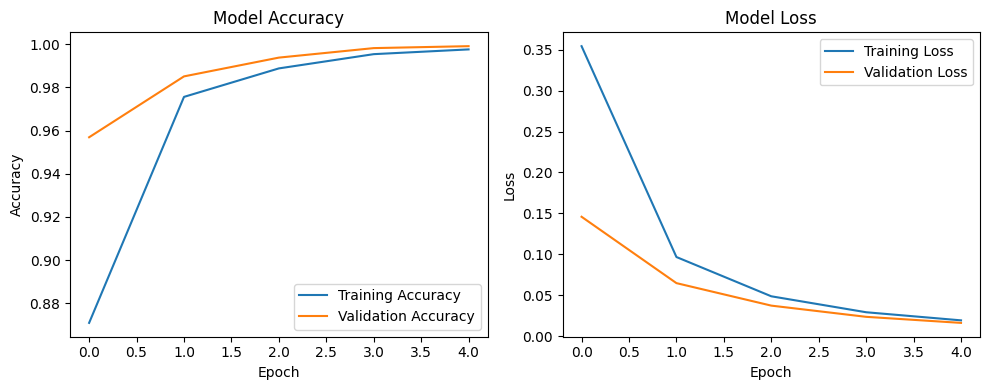

In [72]:
import matplotlib.pyplot as plt

# Create a simple visualization of training history
plt.figure(figsize=(10, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot([0.8709, 0.9756, 0.9888, 0.9954, 0.9976], label='Training Accuracy')
plt.plot([0.9569, 0.9851, 0.9938, 0.9982, 0.9991], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot([0.3543, 0.0966, 0.0486, 0.0291, 0.0192], label='Training Loss')
plt.plot([0.1458, 0.0647, 0.0372, 0.0235, 0.0161], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

This high performance is promising, but we should verify it on our completely separate test set, which the model has never seen during training. This will give us the most reliable measure of how well our model might perform in real-world scenarios.
## Step 4: Evaluate the model's performance on test data
The true test of our model's capabilities comes from evaluating it on our completely separate test dataset. Let's see how our neural network performs when classifying mushrooms it has never encountered before!

In [67]:
# Make predictions on the test data
y_pred=model.predict(X_test)

77/77 [==============================] - 0s 1ms/step


For a binary classification problem like our (poisonous vs edible), the model outputs probabilities between 0 and 1 for each sample. Let's show the first sample's prediction:

In [68]:
# Show the first sample's prediction
y_pred[0]

array([0.00323989], dtype=float32)

This shows the probability for the first mushroom sample in the test set.
The output is a single value between 0 and 1, where:
 - Values closer to 1 indicate the model is more confident that the sample is poisonous.
 - Values closer to 0 indicate the model is more confident that the sample is edible.

For example, our output value is 0.0032, which means that the model is 99.74% confident that the sample is edible.

The model outputs probability values, but for practical mushroom classification, we need definitive "edible" or "poisonous" predictions. We need to convert these continuous probability values into discrete class labels:

In [69]:
import numpy as np

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_final = (y_pred > 0.5).astype(int)

This code performs what's called "thresholding":

1. First, we compare each probability to the threshold value (0.5)
   
   - If probability > 0.5, the result is True (model thinks it's more likely poisonous)
   - If probability ≤ 0.5, the result is False (model thinks it's more likely edible)

2. Then, we convert these True/False values to integers (1/0) with ``.astype(int)``
   
   - True becomes 1 (poisonous)
   - False becomes 0 (edible)

The 0.5 threshold represents the decision boundary - the point where the model is equally confident in either class. We could adjust this threshold if we wanted to be more conservative about certain types of errors (e.g., lowering the threshold would classify more mushrooms as poisonous, reducing the chance of missing toxic ones).


Now, let's visualize the model's prediction accuracy with a **confusion matrix**. 
This will allow us to see how many correct vs incorrect predictions were made using the model above.

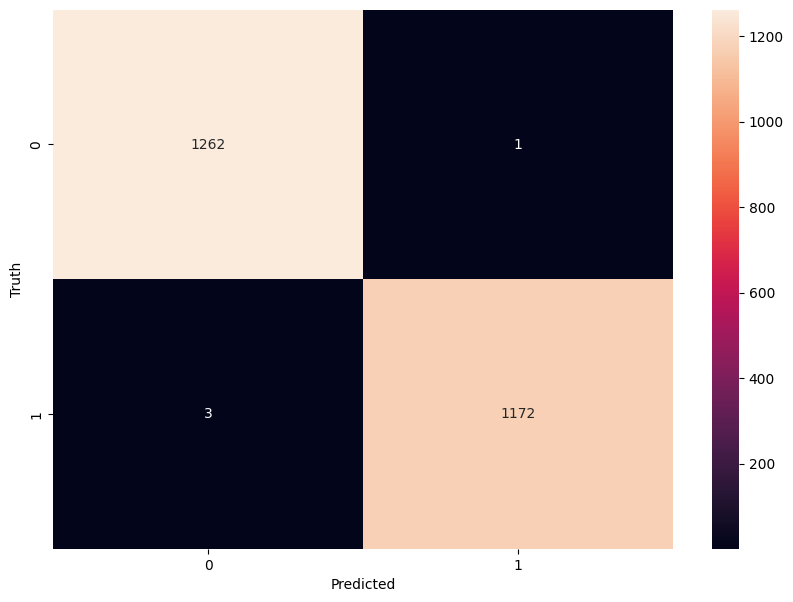

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm=confusion_matrix(y_test,y_pred_final)

# Create visualization
plt.figure(figsize=(10,7))          # Set figure size to 10x7 inches
sns.heatmap(cm,annot=True,fmt='d')  # Create heatmap with annotations and display counts as integers
plt.xlabel('Predicted')             # Label x-axis as 'Predicted'
plt.ylabel('Truth')                 # Label y-axis as 'Truth'
plt.show()                          # Display the plot

The confusion matrix visualization shows how well our model classifies mushrooms as edible or poisonous. The matrix is a 2x2 grid where:

* The y-axis (Truth) shows the actual class of the mushrooms
* The x-axis (Predicted) shows what our model predicted
* Each cell contains the count of predictions falling into that category
* The heatmap coloring provides visual intensity, where lighter colors indicate higher counts

Reading the matrix:

* **Top-left**: True Negatives (TN) - Correctly identified edible mushrooms
* **Top-right**: False Positives (FP) - Edible mushrooms incorrectly classified as poisonous
* **Bottom-left**: False Negatives (FN) - Poisonous mushrooms incorrectly classified as edible
* **Bottom-right**: True Positives (TP) - Correctly identified poisonous mushrooms 

**Key Classification Metrics**

From these confusion matrix values, we can calculate several important evaluation metrics:

| Metric | Definition | Interpretation for Mushrooms |
|--------|------------|----------------------------|
| **Accuracy** | (TP + TN)/(TP + TN + FP + FN) | Percentage of all mushrooms correctly classified |
| **Precision** | TP/(TP + FP) | When model predicts "poisonous," how often is it right? |
| **Recall** | TP/(TP + FN) | Of all poisonous mushrooms, how many did we correctly identify? |
| **F1-Score** | 2 × (Precision × Recall)/(Precision + Recall) | Harmonic mean of precision and recall; useful when you need to balance both |
| **Specificity** | TN/(TN + FP) | Of all edible mushrooms, how many did we correctly identify? |

**Thought Challenge**: Which prediction metric is most important for this model? Why? 

Let's also print the full classification report of this model using code below:

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_final, digits=4))

              precision    recall  f1-score   support

           0     0.9976    0.9992    0.9984      1263
           1     0.9991    0.9974    0.9983      1175

    accuracy                         0.9984      2438
   macro avg     0.9984    0.9983    0.9984      2438
weighted avg     0.9984    0.9984    0.9984      2438



The accuracy of our model is 99.79%.
99.79% of the time, this model predicted the correct label on the test data.

**Thought Challenge**: Did we build a successful model? Why or why not? Is there anything we can do to improve the model?